In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torchmetrics import AUROC, ConfusionMatrix
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import roc_auc_score, auc, roc_curve, RocCurveDisplay, confusion_matrix

import pyreadr
from pyprojroot import here
from itertools import cycle

import plotnine as pn
from plotnine import ggplot, geom_point, geom_boxplot, geom_tile, aes, stat_smooth, facet_wrap, position_jitter, scale_fill_gradient2, theme, theme_bw, guides, scale_color_brewer

import umap
import shap

/Users/alzhang/miniconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
class Net(nn.Module):
    def __init__(self, input_dim, num_classes, dropout = 0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.activation1 = nn.ReLU() # 1
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(512, 64)
        self.activation2 = nn.ReLU() # 2
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        #x = F.softmax(self.fc3(x))
        return x


def train_net(dl, model, loss_fn, optimizer, num_epochs = 500):
    model.train()
    for epoch in range(num_epochs+1):
        loss_total = 0
        for (input, target) in dl:
            optimizer.zero_grad()
            
            output = model(input)
            loss = loss_fn(output, target)
            loss_total += loss
            
            loss.backward()
            optimizer.step()
    
        if (epoch % 100) == 0:
            print("Epoch {}/{}, Loss: {:.3f}".format(epoch,num_epochs, loss_total))


# Doesn't use dl_val; for monitoring
def train_net_val(dl, dl_val, model, loss_fn, optimizer, l1_lambda = 0, num_epochs = 500):
    model.train()

    num_total_samples = dl.dataset.tensors[0].shape[0]

    for epoch in range(num_epochs+1):
        loss_total = 0
        l1_reg_total = 0
        
        for (input, target) in dl:
            optimizer.zero_grad()
            
            output = model(input)
            #output = torch.log(output + 1e-10)
            loss = loss_fn(output, target)

            # Calculate L1 term
            L1_term = torch.tensor(0., requires_grad=True)
            for name, weights in model.named_parameters():
                if 'bias' not in name:
                    weights_sum = torch.sum(torch.abs(weights))
                    L1_term = L1_term + weights_sum
            
            l1_reg = L1_term * l1_lambda * input.shape[0]/num_total_samples
            loss = loss + l1_reg
            
            loss_total += loss
            l1_reg_total += l1_reg
            with torch.no_grad():
                _, train_preds = torch.max(F.softmax(output, dim=1), 1)
                _, train_labels = torch.max(target, 1)
                train_correct = (train_preds == train_labels).sum().item()
            
            loss.backward()
            optimizer.step()
    
        if (epoch % 100) == 0:
            print("Epoch {}/{}, {}/{}, Loss: {:.3f}, L1: {:.3f}".format(epoch,num_epochs, train_correct, len(train_preds),  loss_total, l1_reg_total))
            model.eval()
            with torch.no_grad():
                for (vinput, vtarget) in dl_val:
                    nn_output = F.softmax(model(vinput), dim=1)
                    _, nn_preds = torch.max(nn_output, 1)
        
                    total = target.shape[0]
                    _, true_labels = torch.max(vtarget, 1)
        
                    correct = (nn_preds == true_labels).sum().item()
                    print("Epoch {}/{}, Validation Correct: {}/{}, {:.3f}".format(epoch,num_epochs, correct, len(nn_preds), correct/len(nn_preds)))
            model.train()


def summarise_nn_results(dl, net, num_classes):
    net.eval()
    with torch.inference_mode():
        for (input, target) in dl:
            nn_output = F.softmax(net(input))
            _, nn_preds = torch.max(nn_output, 1)
    
            total = target.shape[0]
            _, true_labels = torch.max(target, 1)
    
            # Evaluation metrics
    
            ## AUC
            correct = (nn_preds == true_labels).sum().item()
            auroc = AUROC(task = "multiclass", num_classes = num_classes, average = 'weighted')
            nn_auroc = auroc(nn_output, true_labels)
    
            ## ROC
            mcroc = MulticlassROC(num_classes = num_classes, thresholds=None)
            mcroc.update(nn_output, true_labels)
    
            ## Confusion matrix
            confmat = ConfusionMatrix(task = "multiclass", num_classes = num_classes).to('mps')
            nn_confmat = confmat(nn_preds, true_labels).cpu()
        
        print("Accuracy on test data {}/{} ({}%), AUC: {:.3f}".format(correct,total,100*correct // total, nn_auroc))
        
        return({'preds': nn_preds, 'proba': nn_output, 'confmat': nn_confmat, 'roc': mcroc})

In [3]:
train_data_file = here('results/classifier/train/beta.rds')
train_metadata_file = here('results/classifier/train/metadata.tsv')
test_data_file = here('results/classifier/test/beta.rds')
test_metadata_file = here('results/classifier/test/metadata.tsv')

train_data = pyreadr.read_r(train_data_file)[None]
test_data = pyreadr.read_r(test_data_file)[None]
train_metadata = pd.read_csv(train_metadata_file, sep='\t')
test_metadata = pd.read_csv(test_metadata_file, sep='\t')


normal_test_data_file = here('results/classifier/test/beta_normal.rds')
normal_test_metadata_file = here('results/merged/metadata_merged_normal.tsv')

normal_test_data = pyreadr.read_r(normal_test_data_file)[None]
normal_test_metadata = pd.read_csv(normal_test_metadata_file, sep='\t')


met_test_data_file = here('results/classifier/test/beta_met.rds')
met_test_metadata_file = here('results/merged/metadata_merged_metastatic.tsv')

met_test_data = pyreadr.read_r(met_test_data_file)[None]
met_test_metadata = pd.read_csv(met_test_metadata_file, sep='\t')

In [4]:
full_data = train_data.join(test_data).join(met_test_data)
full_metadata = pd.concat([train_metadata[['Project ID', 'cancer_type', 'hpv_status', 'Sample Type']], 
                           test_metadata[['Project ID', 'cancer_type', 'hpv_status', 'Sample Type']],
                           met_test_metadata[['Project ID', 'cancer_type', 'hpv_status', 'Sample Type']]])

reducer = umap.UMAP()

full_data_embedded = reducer.fit_transform(full_data.T)

full_metadata['project_id'] = full_metadata['Project ID']

Warning message:Brewer palette Set2 has a maximum of 8 colors Returning the palette you asked for with that many colors
Warning message:Brewer palette Set2 has a maximum of 8 colors Returning the palette you asked for with that many colors


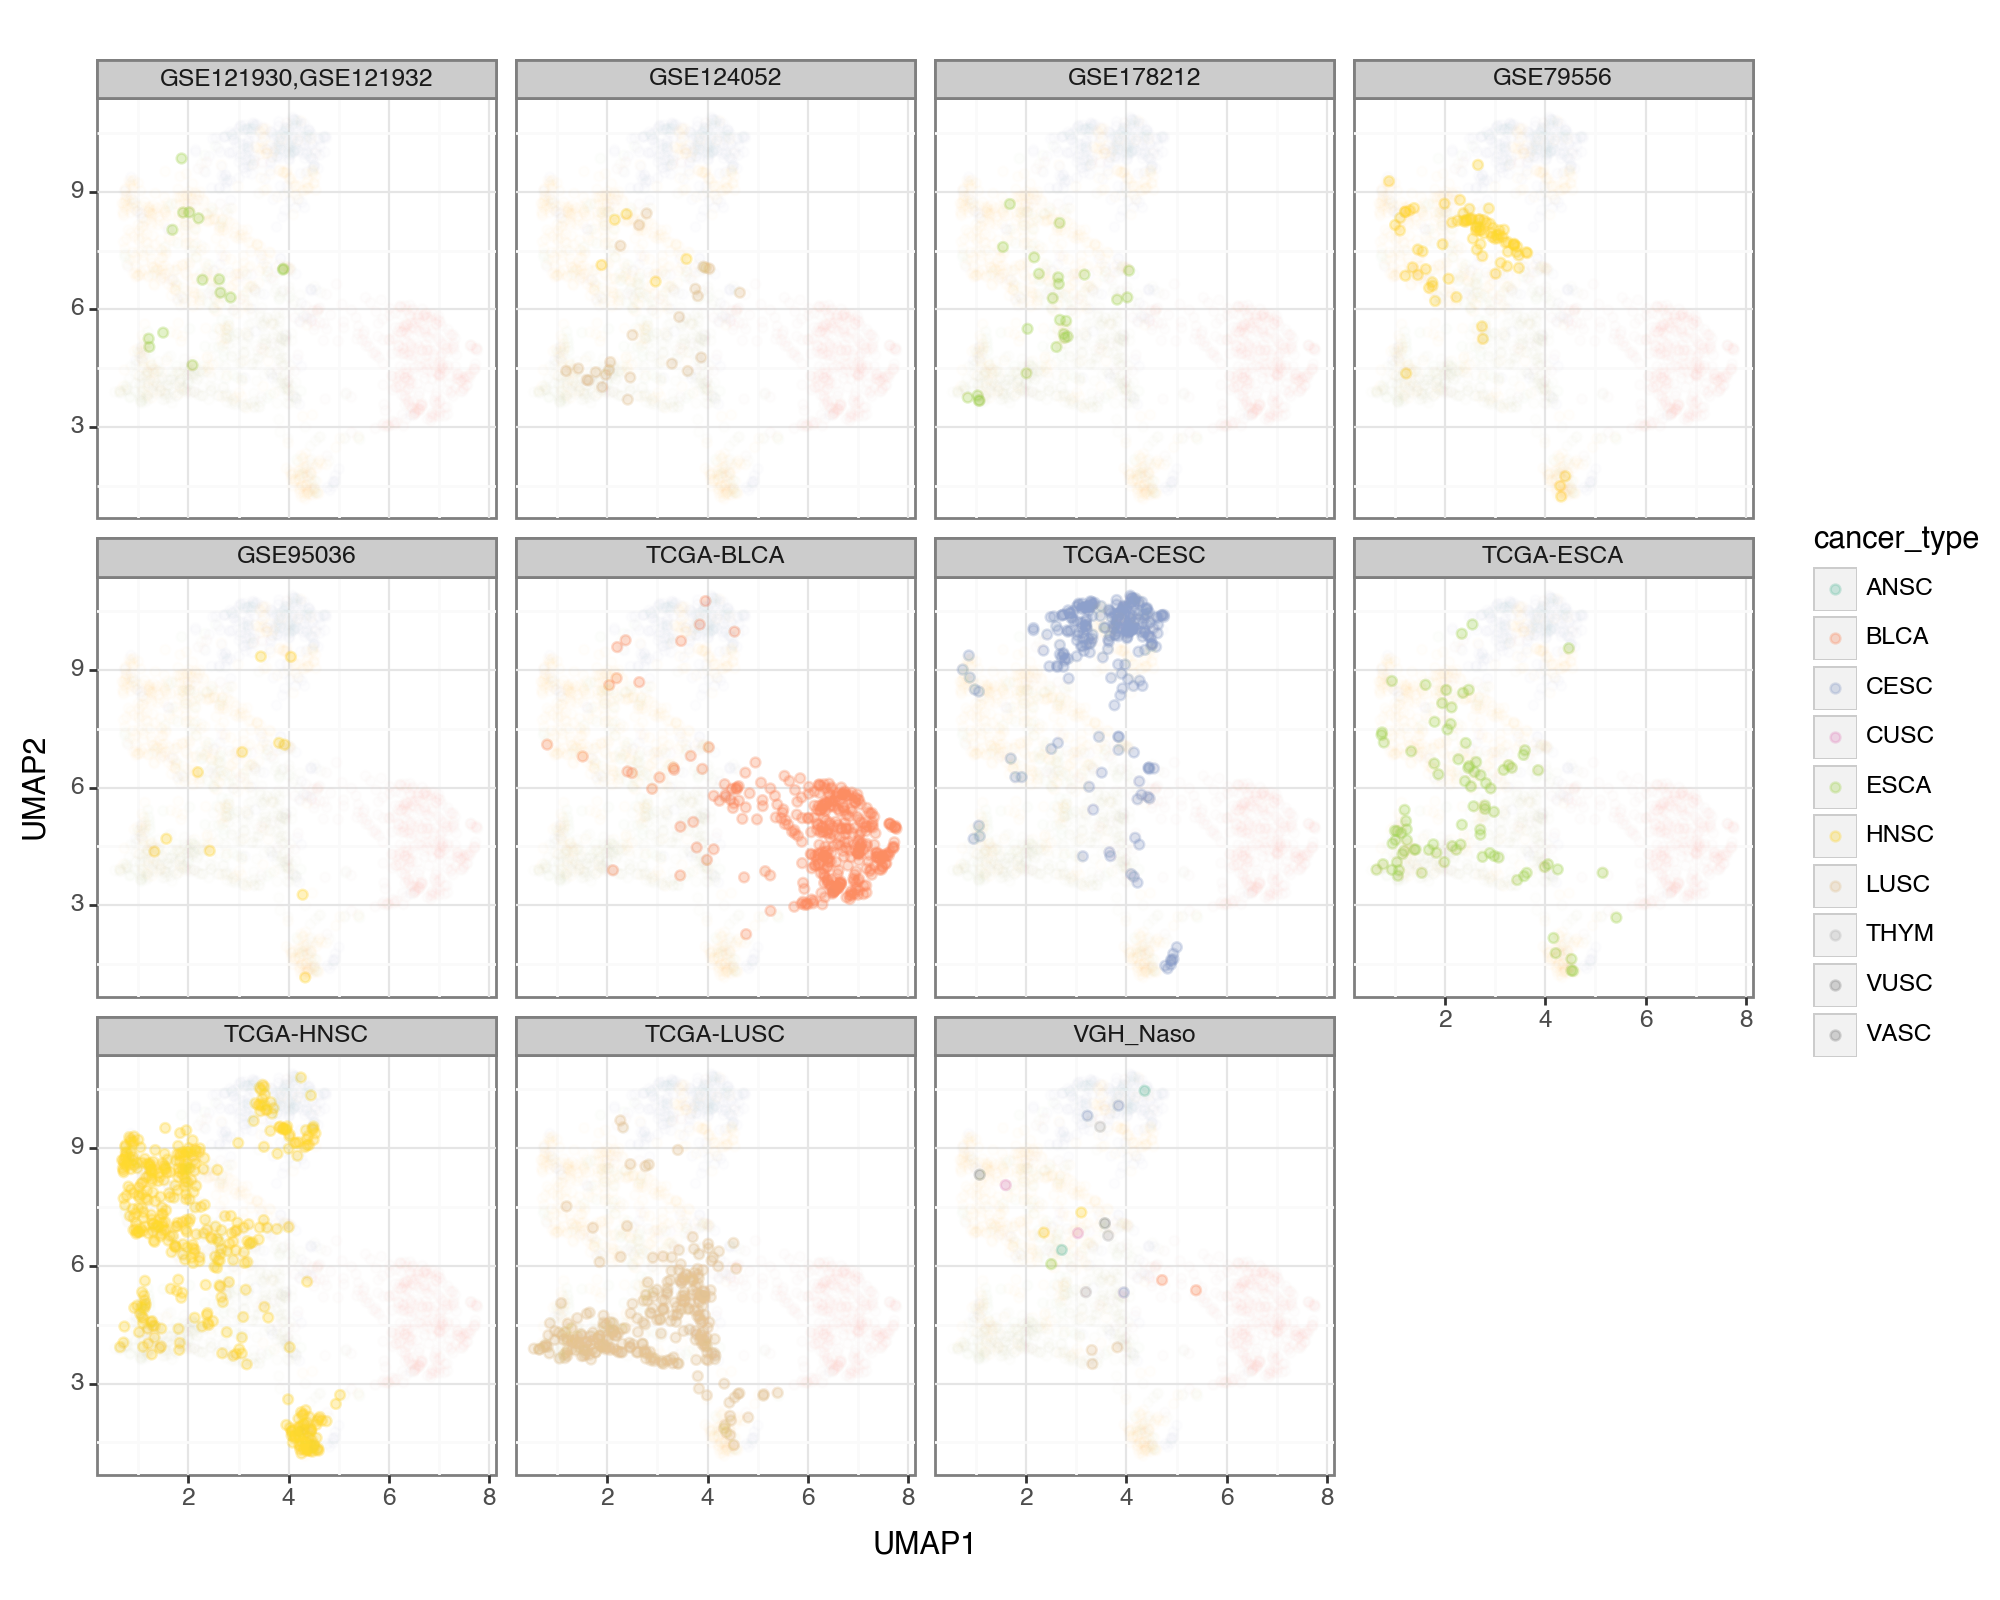

<Figure Size: (1000 x 800)>

In [106]:
dimred_df = pd.DataFrame(full_data_embedded, columns = ['UMAP1', 'UMAP2']).join(full_metadata.reset_index())

dimred_df_nofacet = dimred_df.drop(columns = 'project_id')

(ggplot(dimred_df[dimred_df['Sample Type'] == "Primary Tumor"], aes("UMAP1", "UMAP2")) + 
  geom_point(aes(colour="cancer_type"), alpha = 0.3) +
  geom_point(aes(colour="cancer_type"), data = dimred_df_nofacet, alpha = 0.01) +
  theme_bw() +
  theme(figure_size=(10, 8)) + 
 guides(alpha = False) + 
 scale_color_brewer(type="qual", palette="Set2") + 
 facet_wrap("~ project_id")
)

## Main, without Jurmeister and VGH

In [5]:
num_probes = 10000
selected_probes = train_data.index.values[0:num_probes]
print(selected_probes)

idx_noHeldOut = ~train_metadata['Project ID'].isin(["GSE124052", "VGH_Naso"])
train_metadata_noHeldOut = train_metadata[idx_noHeldOut].reset_index(drop=True)
train_data_noHeldOut = train_data.loc[selected_probes,idx_noHeldOut.values]

idx_test_withHeldOut = test_metadata['Project ID'].isin(["GSE124052", "VGH_Naso"])
idx_met_withHeldOut = met_test_metadata['Project ID'].isin(["GSE124052", "VGH_Naso"])
test_metadata_withHeldOut = pd.concat([test_metadata, train_metadata[~idx_noHeldOut], met_test_metadata[idx_met_withHeldOut]])
test_data_withHeldOut = pd.concat([test_data.loc[selected_probes,:], train_data.loc[selected_probes,~idx_noHeldOut.values], met_test_data.loc[selected_probes,idx_met_withHeldOut.values]], axis = 1)
test_data_withHeldOut = test_data_withHeldOut.loc[:,test_metadata_withHeldOut['sample']]

['cg17300544' 'cg07195011' 'cg21101720' ... 'cg21005853' 'cg08448701'
 'cg20308679']


3 Toronto (LUSC) samples from the above are excluded for having a history of SCC in the past (and as such, not certain diagnoses).

### Remove cases for untrained cancer types

In [9]:
trained_cancer_types = np.unique(train_metadata_noHeldOut['cancer_type'])

test_metadata_withHeldOut_onlyTrained = test_metadata_withHeldOut[test_metadata_withHeldOut['cancer_type'].isin(trained_cancer_types)]
test_data_withHeldOut_onlyTrained = test_data_withHeldOut.loc[:,test_metadata_withHeldOut_onlyTrained['sample']]

In [10]:
test_metadata_withHeldOut_unTrained = test_metadata_withHeldOut[~test_metadata_withHeldOut['cancer_type'].isin(trained_cancer_types)]
test_data_withHeldOut_unTrained = test_data_withHeldOut.loc[:,test_metadata_withHeldOut_unTrained['sample']]

In [9]:
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)
cancer_type_indices = le.fit_transform(train_metadata_noHeldOut['cancer_type'])
ohe.fit_transform(np.array(cancer_type_indices).reshape(-1, 1))

train_metadata_noHeldOut['cancer_type_index'] = cancer_type_indices
test_metadata_withHeldOut_onlyTrained['cancer_type_index'] = le.transform(test_metadata_withHeldOut_onlyTrained['cancer_type'])

num_classes = len(np.unique(cancer_type_indices))

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
train_metadata_noHeldOut.shape

(1062, 42)

## Normal and metastasis

In [110]:
normal_test_metadata['cancer_type_index'] = le.transform(normal_test_metadata['cancer_type'])
normal_test_data_selected = normal_test_data.loc[selected_probes,:]

td_normal = data_utils.TensorDataset(torch.tensor(normal_test_data_selected.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(normal_test_metadata['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
dl_normal = data_utils.DataLoader(td_normal, batch_size = normal_test_metadata.shape[0], shuffle = False)

met_test_metadata_onlyTrained = met_test_metadata[met_test_metadata['cancer_type'].isin(trained_cancer_types)]
met_test_metadata_onlyTrained['cancer_type_index'] = le.transform(met_test_metadata_onlyTrained['cancer_type'])
met_test_data_selected = met_test_data.loc[selected_probes,met_test_metadata_onlyTrained['sample']]

td_met = data_utils.TensorDataset(torch.tensor(met_test_data_selected.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(met_test_metadata_onlyTrained['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
dl_met = data_utils.DataLoader(td_met, batch_size = met_test_metadata_onlyTrained.shape[0], shuffle = False)

print(normal_test_data_selected.shape)
print(met_test_data_selected.shape)

(10000, 118)
(10000, 51)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## POG ONT

In [16]:
full_ont_metadata_file = here('results/POG_nanopore_450k/metadata.tsv')

ont_metadata = pd.read_csv(full_ont_metadata_file, sep='\t')
ont_metadata['sample_suffix'] = ont_metadata['sample'].str.extract(r'(?<=_)([A-Z0-9\\-]+)$')

In [19]:
## Compute weighted means
train_data_sel = train_data_noHeldOut.loc[selected_probes,:]

_ndx = np.argsort(train_metadata_noHeldOut['cancer_type'].values)
_id, _pos, g_count = np.unique(train_metadata_noHeldOut['cancer_type'][_ndx], return_index=True, return_counts=True)

g_sum = np.add.reduceat(np.matrix(train_data_sel).T[_ndx], _pos, axis=0)
class_means = g_sum / g_count[:,None]

weighted_mean = pd.DataFrame(np.mean(class_means, axis = 0).T, columns = ['mean_beta'], index=selected_probes)

In [25]:
nanopore_dir = here('results/POG_nanopore_450k/Downsampled')
ont_matrices = {}

coverages = [0.1, 0.2, 0.5, 0.7, 1, 2, 3, 5, 10, 15, 20, 25, 30]
window_sizes = [0, 50, 100, 150, 200, 250, 300]

for coverage in coverages:
    subdict = {}
    for window_size in window_sizes:
        fname = os.path.join(nanopore_dir, str(coverage), "norm_beta_" + str(window_size) + ".rds")
        print(fname)
        ont_data_raw = pyreadr.read_r(fname)[None]
        ont_data_complete = ont_data_raw.reindex(index=selected_probes).loc[selected_probes,:]
        # Fill NAs with 0.5 (half-half); could try median and mean values too
        #ont_data_complete = ont_data_complete.fillna(value = 0.5)
        # Fill NAs with weighted mean
        beta_fill = pd.concat([weighted_mean] * (ont_data_complete.shape[1]), axis = 1, ignore_index=True)
        beta_fill.columns = ont_data_complete.columns
        ont_data_complete = ont_data_complete.fillna(beta_fill)
        #ont_data_complete = ont_data_complete.dropna(axis = 0, how = 'any', inplace = False)
        #ont_data_complete.columns = ont_data_complete.columns.str.extract(r'(?<=_)([A-Z0-9\\-]+)$')[0]
        subdict[str(window_size)] = ont_data_complete
    ont_matrices[str(coverage)] = subdict

/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.1/norm_beta_0.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.1/norm_beta_50.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.1/norm_beta_100.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.1/norm_beta_150.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.1/norm_beta_200.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.1/norm_beta_250.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.1/norm_beta_300.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.2/norm_beta_0.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/Downsampled/0.2/norm_beta_50.rds
/Users/alzhang/Documents/projects/methsquam/results/POG_nanopore_450k/

In [27]:
## Full coverage, no window

fname = os.path.join(here('results/POG_nanopore_450k/norm_beta.rds'))
pog_full_ont_data = pyreadr.read_r(fname)[None]
pog_full_ont_data_complete = pog_full_ont_data.reindex(index=selected_probes).loc[selected_probes,:]

beta_fill = pd.concat([weighted_mean] * (pog_full_ont_data_complete.shape[1]), axis = 1, ignore_index=True)
beta_fill.columns = pog_full_ont_data_complete.columns
pog_full_ont_data_complete = pog_full_ont_data_complete.fillna(beta_fill)

## VGH ONT

In [ ]:
vgh_ont_metadata_file = here('results/VGH_ONT/metadata.tsv')

vgh_ont_metadata = pd.read_csv(vgh_ont_metadata_file, sep='\t')

In [22]:
vgh_nanopore_dir = here('results/VGH_ONT/Downsampled')
vgh_ont_matrices = {}

vgh_rel_depths = [100]
window_sizes = [0, 50, 100, 150, 200, 250, 300]

for depth in vgh_rel_depths:
    subdict = {}
    for window_size in window_sizes:
        fname = os.path.join(vgh_nanopore_dir, str(depth), "norm_beta_" + str(window_size) + ".rds")
        print(fname)
        ont_data_raw = pyreadr.read_r(fname)[None]
        ont_data_complete = ont_data_raw.reindex(index=selected_probes).loc[selected_probes,:]
        # Fill NAs with weighted mean
        beta_fill = pd.concat([weighted_mean] * (ont_data_complete.shape[1]), axis = 1, ignore_index=True)
        beta_fill.columns = ont_data_complete.columns
        ont_data_complete = ont_data_complete.fillna(beta_fill)
        subdict[str(window_size)] = ont_data_complete
    vgh_ont_matrices[str(depth)] = subdict

/Users/alzhang/Documents/projects/methsquam/results/VGH_ONT/Downsampled/100/norm_beta_0.rds
/Users/alzhang/Documents/projects/methsquam/results/VGH_ONT/Downsampled/100/norm_beta_50.rds
/Users/alzhang/Documents/projects/methsquam/results/VGH_ONT/Downsampled/100/norm_beta_100.rds
/Users/alzhang/Documents/projects/methsquam/results/VGH_ONT/Downsampled/100/norm_beta_150.rds
/Users/alzhang/Documents/projects/methsquam/results/VGH_ONT/Downsampled/100/norm_beta_200.rds
/Users/alzhang/Documents/projects/methsquam/results/VGH_ONT/Downsampled/100/norm_beta_250.rds
/Users/alzhang/Documents/projects/methsquam/results/VGH_ONT/Downsampled/100/norm_beta_300.rds


# Training

In [24]:
RANDOM_SEED = 123456

torch.manual_seed(RANDOM_SEED)
torch.device("mps")

device(type='mps')

In [ ]:
# Move model to GPU
net = Net(num_probes, num_classes, dropout=0.5).to('mps')

optimizer = torch.optim.AdamW(net.parameters(), lr = 1e-4, weight_decay=1e-2, eps=1e-8)
criterion = nn.CrossEntropyLoss()

# weighted sampler
class_weights = 1./train_metadata_noHeldOut['cancer_type_index'].value_counts().sort_index().values
print(class_weights)
sample_weights = [class_weights[train_metadata_noHeldOut['cancer_type_index'].values[i]] for i in range(int(train_metadata_noHeldOut.shape[0]))]
sampler = torch.utils.data.sampler.WeightedRandomSampler(torch.DoubleTensor(sample_weights), num_samples=int(train_metadata_noHeldOut.shape[0]))
train_td_noHeldOut = data_utils.TensorDataset(torch.tensor(train_data_noHeldOut.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(train_metadata_noHeldOut['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
train_dl_noHeldOut = data_utils.DataLoader(train_td_noHeldOut, sampler=sampler, batch_size=128)

In [281]:
train_net_val(dl = train_dl_noHeldOut, dl_val = dl_met, model = net, 
              loss_fn = criterion, optimizer = optimizer, l1_lambda=2e-2, num_epochs = 100)

Epoch 0/100, 35/38, Loss: 6.118, L1: 4.488
Epoch 0/100, Validation Correct: 47/51, 0.922
Epoch 100/100, 38/38, Loss: 5.928, L1: 4.477
Epoch 100/100, Validation Correct: 48/51, 0.941


In [287]:
train_metadata_noHeldOut.shape

(1062, 42)

In [288]:
torch.save(net.state_dict(), here('results/classifier/nn_state.pt'))

# Test

## TCGA + others (including Jurmeister)

In [282]:
test_td_withHeldOut_onlyTrained = data_utils.TensorDataset(torch.tensor(test_data_withHeldOut_onlyTrained.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(test_metadata_withHeldOut_onlyTrained['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
test_dl_withHeldOut_onlyTrained = data_utils.DataLoader(test_td_withHeldOut_onlyTrained, batch_size = test_metadata_withHeldOut_onlyTrained.shape[0], shuffle = False)

nn_results2 = summarise_nn_results(test_dl_withHeldOut_onlyTrained, net, num_classes)

sns.heatmap(np.array(nn_results2['confmat']), annot = True, 
            xticklabels = le.inverse_transform(range(num_classes)), 
            yticklabels = le.inverse_transform(range(num_classes)), 
            fmt='g')

fig_, ax_ = nn_results2['roc'].plot(score=True)

Accuracy on test data 521/544 (95%), AUC: 0.998


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


## TCGA and others (no Jurmeister)

In [289]:
test_data_noHeldOut = test_data_withHeldOut_onlyTrained.loc[:,(~test_metadata_withHeldOut_onlyTrained['Project ID'].isin(["GSE124052", "VGH_Naso"])).values]
test_metadata_noHeldOut = test_metadata_withHeldOut_onlyTrained[~test_metadata_withHeldOut_onlyTrained['Project ID'].isin(["GSE124052", "VGH_Naso"])]

test_td_noHeldOut = data_utils.TensorDataset(torch.tensor(test_data_noHeldOut.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(test_metadata_noHeldOut['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
test_dl_noHeldOut = data_utils.DataLoader(test_td_noHeldOut, batch_size = test_metadata_noHeldOut.shape[0], shuffle = False)

nn_results2_noHeldOut = summarise_nn_results(test_dl_noHeldOut, net, num_classes)

sns.heatmap(np.array(nn_results2_noHeldOut['confmat']), annot = True, 
            xticklabels = le.inverse_transform(range(num_classes)), 
            yticklabels = le.inverse_transform(range(num_classes)), 
            fmt='g')

fig_, ax_ = nn_results2_noHeldOut['roc'].plot(score=True)

Accuracy on test data 440/458 (96%), AUC: 0.999


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [291]:
test_nn_proba = pd.DataFrame(nn_results2_noHeldOut['proba'].to('cpu'), columns = le.classes_)
test_nn_proba = pd.concat([test_metadata_noHeldOut['sample'].reset_index(drop=True), test_nn_proba.reset_index(drop=True)], axis = 1)
test_nn_proba.to_csv(here('results/classifier/test_nn_proba.tsv'), sep='\t', index=False)

## Jurmeister

In [292]:
test_data_onlyJurmeister = test_data_withHeldOut_onlyTrained.loc[:,(test_metadata_withHeldOut_onlyTrained['Project ID'] == "GSE124052").values]
test_metadata_onlyJurmeister = test_metadata_withHeldOut_onlyTrained[test_metadata_withHeldOut_onlyTrained['Project ID'] == "GSE124052"]

test_td_onlyJurmeister = data_utils.TensorDataset(torch.tensor(test_data_onlyJurmeister.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(test_metadata_onlyJurmeister['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
test_dl_onlyJurmeister = data_utils.DataLoader(test_td_onlyJurmeister, batch_size = test_metadata_onlyJurmeister.shape[0], shuffle = False)

nn_results2_onlyJurmeister = summarise_nn_results(test_dl_onlyJurmeister, net, num_classes)

sns.heatmap(np.array(nn_results2_onlyJurmeister['confmat']), annot = True, 
            xticklabels = le.inverse_transform(range(num_classes)), 
            yticklabels = le.inverse_transform(range(num_classes)), 
            fmt='g')

fig_, ax_ = nn_results2_onlyJurmeister['roc'].plot(score=True)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy on test data 58/61 (95%), AUC: 0.976


No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score


In [293]:
jurmeister_nn_proba = pd.DataFrame(nn_results2_onlyJurmeister['proba'].to('cpu'), columns = le.classes_)
jurmeister_nn_proba = pd.concat([test_metadata_onlyJurmeister['sample'].reset_index(drop=True), jurmeister_nn_proba.reset_index(drop=True)], axis = 1)

jurmeister_nn_proba.to_csv(here('results/classifier/jurmeister_nn_proba.tsv'), sep='\t', index=False)

## Toronto

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score


Accuracy on test data 39/41 (95%), AUC: 0.000


No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score


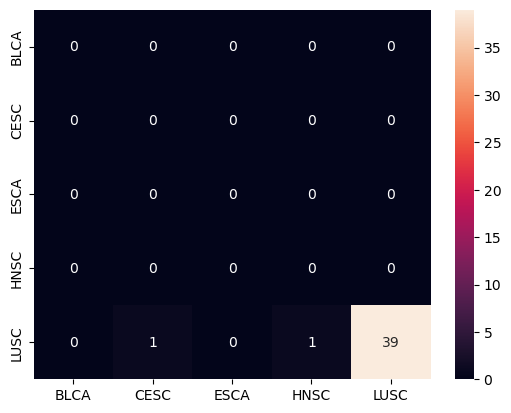

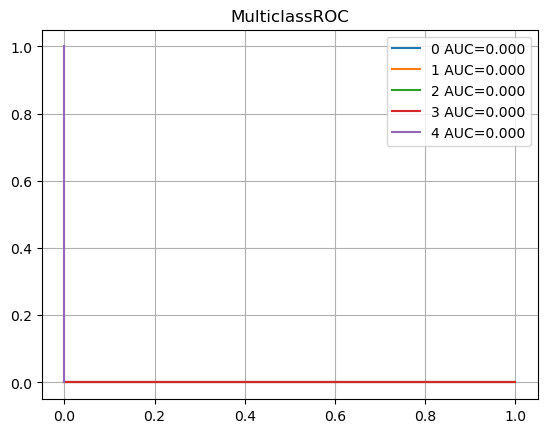

In [19]:
test_data_onlyToronto = test_data_withHeldOut_onlyTrained.loc[:,(test_metadata_withHeldOut_onlyTrained['Project ID'] == "IMPACT").values]
test_metadata_onlyToronto = test_metadata_withHeldOut_onlyTrained[test_metadata_withHeldOut_onlyTrained['Project ID'] == "IMPACT"]

test_td_onlyToronto = data_utils.TensorDataset(torch.tensor(test_data_onlyToronto.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(test_metadata_onlyToronto['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
test_dl_onlyToronto = data_utils.DataLoader(test_td_onlyToronto, batch_size = test_metadata_onlyToronto.shape[0], shuffle = False)

nn_results2_onlyToronto = summarise_nn_results(test_dl_onlyToronto, net_reloaded, num_classes)

sns.heatmap(np.array(nn_results2_onlyToronto['confmat']), annot = True, 
            xticklabels = le.inverse_transform(range(num_classes)), 
            yticklabels = le.inverse_transform(range(num_classes)), 
            fmt='g')

fig_, ax_ = nn_results2_onlyToronto['roc'].plot(score=True)

In [21]:
toronto_nn_proba = pd.DataFrame(nn_results2_onlyToronto['proba'].to('cpu'), columns = le.classes_)
toronto_nn_proba = pd.concat([test_metadata_onlyToronto['sample'].reset_index(drop=True), toronto_nn_proba.reset_index(drop=True)], axis = 1)

toronto_nn_proba.to_csv(here('results/classifier/toronto_nn_proba.tsv'), sep='\t', index=False)

In [22]:
print(toronto_nn_proba)

         sample          BLCA          CESC          ESCA      HNSC      LUSC
0     Toronto 6  1.941272e-04  3.496496e-06  1.492931e-03  0.033277  0.965033
1    Toronto 16  1.285180e-03  8.141576e-05  9.624843e-03  0.040076  0.948933
2    Toronto 20  3.232419e-05  1.936693e-08  5.969960e-06  0.010293  0.989668
3    Toronto 23  7.877356e-03  9.665899e-01  2.708475e-04  0.025260  0.000002
4    Toronto 27  3.160140e-06  3.070688e-09  1.583078e-05  0.014859  0.985122
5    Toronto 50  1.614494e-04  1.248133e-07  8.621828e-06  0.034242  0.965588
6    Toronto 55  2.113917e-04  2.193981e-06  6.128869e-04  0.037482  0.961691
7    Toronto 56  7.674935e-04  1.356727e-05  1.380421e-03  0.063476  0.934363
8    Toronto 57  4.736124e-03  4.782116e-04  2.072702e-02  0.090091  0.883967
9    Toronto 62  7.972151e-04  2.717416e-06  1.001218e-04  0.030718  0.968382
10   Toronto 64  8.128043e-04  3.495446e-05  3.488730e-03  0.200994  0.794669
11   Toronto 66  2.876620e-02  1.599106e-02  1.629034e-02  0.846

## VGH cohort

In [294]:
test_data_onlyVGH_onlyTrained = test_data_withHeldOut_onlyTrained.loc[:,(test_metadata_withHeldOut_onlyTrained['Project ID'] == "VGH_Naso").values]
test_metadata_onlyVGH_onlyTrained = test_metadata_withHeldOut_onlyTrained[test_metadata_withHeldOut_onlyTrained['Project ID'] == "VGH_Naso"]

test_td_onlyVGH_onlyTrained = data_utils.TensorDataset(torch.tensor(test_data_onlyVGH_onlyTrained.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(test_metadata_onlyVGH_onlyTrained['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
test_dl_onlyVGH_onlyTrained = data_utils.DataLoader(test_td_onlyVGH_onlyTrained, batch_size = test_metadata_onlyVGH_onlyTrained.shape[0], shuffle = False)

nn_results2_onlyVGH_onlyTrained = summarise_nn_results(test_dl_onlyVGH_onlyTrained, net, num_classes)

sns.heatmap(np.array(nn_results2_onlyVGH_onlyTrained['confmat']), annot = True, 
            xticklabels = le.inverse_transform(range(num_classes)), 
            yticklabels = le.inverse_transform(range(num_classes)), 
            fmt='g')

fig_, ax_ = nn_results2_onlyVGH_onlyTrained['roc'].plot(score=True)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy on test data 23/25 (92%), AUC: 0.996


In [295]:
vgh_onlyTrained_nn_proba = pd.DataFrame(nn_results2_onlyVGH_onlyTrained['proba'].to('cpu'), columns = le.classes_)
vgh_onlyTrained_nn_proba = pd.concat([test_metadata_onlyVGH_onlyTrained['sample'].reset_index(drop=True), vgh_onlyTrained_nn_proba.reset_index(drop=True)], axis = 1)

vgh_onlyTrained_nn_proba.to_csv(here('results/classifier/vgh_onlyTrained_nn_proba.tsv'), sep='\t', index=False)

## VGH cohort (untrained)

In [19]:
def test_untrained(net, dat):
    net.eval()
    with torch.inference_mode():
        nn_output = F.softmax(net(dat))
        _, nn_preds = torch.max(nn_output, 1)

    return(nn_output)

In [29]:
# BLCA -- CESC -- ESCA -- HNSC -- LUSC

vgh_untrained_proba_result = test_untrained(net_reloaded, torch.tensor(test_data_withHeldOut_unTrained.astype('float32').T.values, device = "mps"))

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
test_metadata_withHeldOut_unTrained[['sample', 'cancer_type', 'primary_diagnosis', 'history of other squamous cell carcinomas of other origin?']].reset_index(drop=True)

In [34]:
vgh_untrained_proba = pd.DataFrame(vgh_untrained_proba_result.to('cpu'), index=test_data_withHeldOut_unTrained.columns, columns = le.classes_).reset_index(drop=False, names=['sample'])
vgh_untrained_proba.to_csv(here('results/classifier/vgh_untrained_nn_proba.tsv'), sep='\t', index=False)

vgh_untrained_proba

,sample,BLCA,CESC,ESCA,HNSC,LUSC
0,VS23-27693,0.006730,0.983258,0.000061,0.009951,3.715880e-07
1,VS22-45233,0.000881,0.001157,0.001792,0.992598,3.571388e-03
2,VS22-33851,0.001218,0.000212,0.001452,0.892317,1.048007e-01
3,VS23-39314,0.132959,0.677526,0.001107,0.188009,3.985703e-04
4,VS24-10377,0.082769,0.005856,0.004879,0.231401,6.750945e-01
5,VS20-21160,0.000027,0.000333,0.000096,0.999529,1.423732e-05
6,VS23-35932,0.006114,0.004390,0.005652,0.954919,2.892475e-02
7,VS22-27497,0.011959,0.004575,0.028830,0.782235,1.724012e-01
8,VS23-42248,0.012697,0.077833,0.013785,0.892543,3.141479e-03
9,VS23-48243,0.010561,0.891337,0.009252,0.088809,4.067515e-05


## Normal

In [296]:
nn_results_normal = summarise_nn_results(dl_normal, net, num_classes)

sns.heatmap(np.array(nn_results_normal['confmat']), annot = True, 
            xticklabels = le.inverse_transform(range(num_classes)), 
            yticklabels = le.inverse_transform(range(num_classes)), 
            fmt='g')

fig_, ax_ = nn_results_normal['roc'].plot(score=True)

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy on test data 109/118 (92%), AUC: 0.998


In [297]:
normal_nn_proba = pd.DataFrame(nn_results_normal['proba'].to('cpu'), columns = le.classes_)
normal_nn_proba = pd.concat([normal_test_metadata['sample'].reset_index(drop=True), normal_nn_proba.reset_index(drop=True)], axis = 1)

normal_nn_proba.to_csv(here('results/classifier/normal_nn_proba.tsv'), sep='\t', index=False)

## Metastasis

In [298]:
nn_results_met = summarise_nn_results(dl_met, net, num_classes)

sns.heatmap(np.array(nn_results_met['confmat']), annot = True, 
            xticklabels = le.inverse_transform(range(num_classes)), 
            yticklabels = le.inverse_transform(range(num_classes)), 
            fmt='g')

fig_, ax_ = nn_results_met['roc'].plot(score=True)

Accuracy on test data 48/51 (94%), AUC: 0.996


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [299]:
met_nn_proba = pd.DataFrame(nn_results_met['proba'].to('cpu'), columns = le.classes_)
met_nn_proba = pd.concat([met_test_metadata_onlyTrained['sample'].reset_index(drop=True), met_nn_proba.reset_index(drop=True)], axis = 1)

met_nn_proba.to_csv(here('results/classifier/met_nn_proba.tsv'), sep='\t', index=False)

In [300]:
met_nn_proba

,sample,BLCA,CESC,ESCA,HNSC,LUSC
0,Case_01,0.003803,4.277106e-03,1.818062e-01,0.551773,2.583409e-01
1,Case_02,0.001566,1.065489e-03,1.000400e-01,0.605941,2.913876e-01
2,Case_03,0.000065,7.032917e-06,1.458813e-02,0.518197,4.671428e-01
3,Case_04,0.000115,5.258070e-04,3.472339e-04,0.998897,1.146453e-04
4,Case_05,0.003844,7.343648e-03,5.758870e-03,0.976680,6.373139e-03
5,Case_06,0.005554,2.222321e-03,5.517390e-02,0.549440,3.876098e-01
6,Case_07,0.000003,3.078635e-06,4.620296e-03,0.989039,6.334745e-03
7,Case_08,0.000009,6.080179e-05,1.810181e-02,0.980305,1.523272e-03
8,Case_09,0.000162,1.896822e-05,2.868737e-02,0.116064,8.550671e-01
9,Case_10,0.000079,1.378086e-04,1.346612e-02,0.970695,1.562155e-02


## ONT

### POG

In [20]:
net_reloaded = Net(10000, num_classes, dropout=0.5).to('mps')
net_reloaded.load_state_dict(torch.load(here('results/classifier/nn_state.pt')))

<All keys matched successfully>

In [30]:
coverages = [0.1, 0.2, 0.5, 0.7, 1, 2, 3, 5, 10, 15, 20, 25, 30]
window_sizes = [0, 50, 100, 150, 200, 250, 300]
in_group_ont_idxs = ont_metadata['cancer_type'].isin(['HNSC', 'CESC', 'LUSC', 'ESCA'])

ont_metadata_ingroup = ont_metadata.loc[in_group_ont_idxs.values,:]
ont_metadata_ingroup['cancer_type_index'] = le.transform(ont_metadata_ingroup['cancer_type'])

pog_nn_probas_dict = []

for coverage in coverages:
    subdict = {}
    for window_size in window_sizes:
        sample_overlaps = np.intersect1d(ont_metadata_ingroup['sample'], ont_matrices[str(coverage)][str(window_size)].columns)
        ont_metadata_ingroup_overlaps = ont_metadata_ingroup.iloc[pd.Index(ont_metadata_ingroup['sample']).get_indexer(sample_overlaps)].reset_index(inplace=False,drop=True)
        print(ont_metadata_ingroup_overlaps['sample'])

        test_dat = ont_matrices[str(coverage)][str(window_size)].loc[:,sample_overlaps]
        print(test_dat.columns)
        #print(np.mean(test_dat.astype('float32').T.values))

        td = data_utils.TensorDataset(torch.tensor(test_dat.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(ont_metadata_ingroup_overlaps['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
        dl = data_utils.DataLoader(td, batch_size = ont_metadata_ingroup_overlaps.shape[0], shuffle = False)
        
        pog_nn_results = summarise_nn_results(dl, net_reloaded, num_classes)
        
        pog_nn_proba = pd.DataFrame(pog_nn_results['proba'].to('cpu'), index=test_dat.columns, columns = le.classes_).reset_index(drop=False, names=['sample'])
        pog_nn_proba['window_size'] = window_size
        pog_nn_proba['coverage'] = coverage
        pog_nn_probas_dict.append(pog_nn_proba)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score


Accuracy on test data 8/16 (50%), AUC: 0.715
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 9/16 (56%), AUC: 0.765
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F9

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 10/16 (62%), AUC: 0.860
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 9/16 (56%), AUC: 0.830
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 12/16 (75%), AUC: 0.990
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 12/16 (75%), AUC: 0.980
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 11/16 (68%), AUC: 0.960
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 13/16 (81%), AUC: 1.000
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 13/16 (81%), AUC: 0.987
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 12/16 (75%), AUC: 0.974
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 12/16 (75%), AUC: 0.977
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 12/16 (75%), AUC: 0.977
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 15/16 (93%), AUC: 0.995
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 15/16 (93%), AUC: 0.990
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 13/16 (81%), AUC: 0.982
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_F94519
5             41813_T_F94516
6                    F138888
7                    F148364
8                    F148365
9                    F148367
10                   F148369
11                   F148370
12                   F148374
13                   F148375
14                   F148376
15                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '33373_T_F94422',
       '36067_T_F94494', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148364', 'F148365', 'F148367', 'F148369', 'F148370', 'F148374',
       'F148375', 'F148376', 'F148377'],
      dtype='object')
Accuracy on test data 13/16 (81%), AUC: 0.982
0     32395_T_F112331-F94490
1            32655_T_F111504
2             33373_T_F94422
3             36067_T_F94494
4             40168_T_

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score


Accuracy on test data 13/15 (86%), AUC: 0.988
0     32395_T_F112331-F94490
1            32655_T_F111504
2             36067_T_F94494
3             40168_T_F94519
4             41813_T_F94516
5                    F138888
6                    F148364
7                    F148365
8                    F148367
9                    F148369
10                   F148370
11                   F148374
12                   F148375
13                   F148376
14                   F148377
Name: sample, dtype: object
Index(['32395_T_F112331-F94490', '32655_T_F111504', '36067_T_F94494',
       '40168_T_F94519', '41813_T_F94516', 'F138888', 'F148364', 'F148365',
       'F148367', 'F148369', 'F148370', 'F148374', 'F148375', 'F148376',
       'F148377'],
      dtype='object')
Accuracy on test data 12/15 (80%), AUC: 0.979
0     32395_T_F112331-F94490
1            32655_T_F111504
2             36067_T_F94494
3             40168_T_F94519
4             41813_T_F94516
5                    F138888
6          

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

Accuracy on test data 9/11 (81%), AUC: 0.989
0     32655_T_F111504
1      40168_T_F94519
2      41813_T_F94516
3             F138888
4             F148365
5             F148367
6             F148369
7             F148370
8             F148374
9             F148375
10            F148376
Name: sample, dtype: object
Index(['32655_T_F111504', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148365', 'F148367', 'F148369', 'F148370', 'F148374', 'F148375',
       'F148376'],
      dtype='object')
Accuracy on test data 9/11 (81%), AUC: 0.989
0     32655_T_F111504
1      40168_T_F94519
2      41813_T_F94516
3             F138888
4             F148365
5             F148367
6             F148369
7             F148370
8             F148374
9             F148375
10            F148376
Name: sample, dtype: object
Index(['32655_T_F111504', '40168_T_F94519', '41813_T_F94516', 'F138888',
       'F148365', 'F148367', 'F148369', 'F148370', 'F148374', 'F148375',
       'F148376'],
      dtype='objec

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
Implicit dimension choice for softmax has been deprecated. Change the call to include di

In [31]:
## Full coverage POG
pog_full_ont_data_complete

sample_overlaps = np.intersect1d(ont_metadata_ingroup['sample'], pog_full_ont_data_complete.columns)
ont_metadata_ingroup_overlaps = ont_metadata_ingroup.iloc[pd.Index(ont_metadata_ingroup['sample']).get_indexer(sample_overlaps)]

test_dat = pog_full_ont_data_complete.loc[:,sample_overlaps]

td = data_utils.TensorDataset(torch.tensor(test_dat.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(ont_metadata_ingroup_overlaps['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
dl = data_utils.DataLoader(td, batch_size = ont_metadata_ingroup_overlaps.shape[0], shuffle = False)

pog_full_nn_results = summarise_nn_results(dl, net_reloaded, num_classes)

pog_nn_proba_full = pd.DataFrame(pog_full_nn_results['proba'].to('cpu'), index=test_dat.columns, columns = le.classes_).reset_index(drop=False, names=['sample'])

Accuracy on test data 15/16 (93%), AUC: 0.995


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score


In [33]:
pog_nn_proba_full

,sample,BLCA,CESC,ESCA,HNSC,LUSC
0,32395_T_F112331-F94490,6.477440e-03,1.951358e-03,0.003255,0.929541,5.877528e-02
1,32655_T_F111504,3.556981e-04,1.240756e-03,0.004002,0.992716,1.685693e-03
2,33373_T_F94422,4.020275e-02,5.781069e-01,0.020798,0.359823,1.069678e-03
3,36067_T_F94494,2.095420e-04,5.345636e-03,0.000128,0.994312,4.828288e-06
4,40168_T_F94519,8.848242e-03,9.402518e-03,0.276918,0.337763,3.670684e-01
5,41813_T_F94516,6.609681e-06,1.394023e-05,0.001513,0.996719,1.747194e-03
6,F138888,3.702600e-04,2.639695e-03,0.906636,0.053385,3.696831e-02
7,F148364,9.686029e-05,8.954054e-07,0.000541,0.030932,9.684293e-01
8,F148365,1.103989e-04,2.639310e-05,0.001540,0.955695,4.262889e-02
9,F148367,6.813888e-05,2.569005e-08,0.000003,0.016336,9.835927e-01


In [34]:
pog_nn_probas_dict

[                    sample      BLCA      CESC      ESCA      HNSC      LUSC  \
 0   32395_T_F112331-F94490  0.112739  0.030370  0.001646  0.813459  0.041786   
 1          32655_T_F111504  0.037698  0.006218  0.018564  0.382381  0.555138   
 2           33373_T_F94422  0.067787  0.027049  0.004217  0.839925  0.061022   
 3           36067_T_F94494  0.040496  0.022739  0.005970  0.887827  0.042968   
 4           40168_T_F94519  0.018043  0.024715  0.025746  0.885934  0.045563   
 5           41813_T_F94516  0.016213  0.009704  0.004708  0.939350  0.030026   
 6                  F138888  0.004738  0.003224  0.008677  0.934370  0.048990   
 7                  F148364  0.052930  0.007364  0.005709  0.652436  0.281561   
 8                  F148365  0.029852  0.008626  0.006738  0.839427  0.115357   
 9                  F148367  0.008595  0.003163  0.022346  0.762219  0.203677   
 10                 F148369  0.031175  0.018786  0.002817  0.923767  0.023455   
 11                 F148370 

In [35]:
pog_nn_probas_df = pd.concat(pog_nn_probas_dict)
pog_nn_probas_df.to_csv(here('results/classifier/pog_ont_nn_proba_downsampled.tsv'), sep='\t', index=False)

pog_nn_proba_full.to_csv(here('results/classifier/pog_ont_nn_proba.tsv'), sep='\t', index=False)

### VGH

In [42]:
net_reloaded = Net(10000, num_classes, dropout=0.5).to('mps')
net_reloaded.load_state_dict(torch.load(here('results/classifier/nn_state.pt')))

<All keys matched successfully>

In [27]:
vgh_in_group_ont_idxs = vgh_ont_metadata['cancer_type'].isin(['HNSC', 'BLCA', 'CESC', 'LUSC'])
vgh_ont_metadata_ingroup = vgh_ont_metadata.loc[vgh_in_group_ont_idxs.values,:]
vgh_ont_metadata_ingroup['cancer_type_index'] = le.transform(vgh_ont_metadata_ingroup['cancer_type'])

test_dat = vgh_ont_matrices['100']['50'].loc[:,vgh_ont_metadata_ingroup['sample']]

print(np.mean(test_dat.astype('float32').T.values))

print(test_dat.shape)
print(test_dat)

td = data_utils.TensorDataset(torch.tensor(test_dat.astype('float32').T.values, device = "mps"), torch.tensor(ohe.transform(np.array(vgh_ont_metadata_ingroup['cancer_type_index']).reshape(-1, 1)).astype('float32'), device = "mps"))
dl = data_utils.DataLoader(td, batch_size = vgh_ont_metadata_ingroup.shape[0], shuffle = False)

vgh_nn_results = summarise_nn_results(dl, net_reloaded, num_classes)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.40782204
(10000, 20)
            VOA14466a  VOA17029a  VOA18404a  VOA16804a  VOA16514a     B-155  \
cg17300544   0.000000   0.000000   0.000000   0.000000   0.000000  0.000000   
cg07195011   0.545455   0.312500   0.076923   1.000000   0.000000  0.000000   
cg21101720   0.422703   0.422703   0.434783   0.422703   0.000000  0.352941   
cg01030534   0.777778   0.000000   0.000000   0.000000   0.414230  0.428571   
cg22830113   0.375000   0.956522   0.000000   0.380593   0.000000  0.250000   
...               ...        ...        ...        ...        ...       ...   
cg26023087   0.666667   0.000000   0.000000   0.353642   0.000000  0.000000   
cg09832443   1.000000   0.800000   1.000000   1.000000   1.000000  0.250000   
cg21005853   0.000000   0.000000   0.193616   0.000000   0.083333  0.136364   
cg08448701   0.386364   0.818182   0.500000   0.133333   0.115385  0.083333   
cg20308679   0.250000   0.000000   0.000000   0.142857   0.255772  0.000000   

             B-167-T  LT17-0

No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score


In [48]:
vgh_nn_results

vgh_nn_proba = pd.DataFrame(vgh_nn_results['proba'].to('cpu'), index=test_dat.columns, columns = le.classes_).reset_index(drop=False, names=['sample'])
vgh_nn_proba.to_csv(here('results/classifier/vgh_ont_nn_proba.tsv'), sep='\t', index=False)

pd.DataFrame(torch.round(vgh_nn_results['proba'].to('cpu'), decimals=3, out=None), index=test_dat.columns, columns = le.classes_)

,BLCA,CESC,ESCA,HNSC,LUSC
VOA14466a,0.033,0.896,0.013,0.057,0.000
VOA17029a,0.003,0.974,0.000,0.023,0.000
VOA18404a,0.585,0.077,0.002,0.144,0.191
VOA16804a,0.006,0.975,0.001,0.019,0.000
VOA16514a,0.042,0.876,0.052,0.029,0.001
B-155,0.966,0.006,0.000,0.014,0.014
B-167-T,0.925,0.009,0.000,0.002,0.064
LT17-018-TB1,0.008,0.000,0.003,0.019,0.969
NASO-006-1,0.118,0.055,0.005,0.780,0.042
LT19-031-TB1,0.000,0.000,0.000,0.075,0.925


### VGH ONT untrained

In [31]:
vgh_out_group_ont_idxs = ~vgh_ont_metadata['cancer_type'].isin(['HNSC', 'BLCA', 'CESC', 'LUSC'])
vgh_ont_metadata_outgroup = vgh_ont_metadata.loc[vgh_out_group_ont_idxs.values,:]

vgh_out_test_dat = vgh_ont_matrices['100']['50'].loc[:,vgh_ont_metadata_outgroup['sample']]

print(np.mean(vgh_out_test_dat.astype('float32').T.values))

print(vgh_out_test_dat.shape)
print(vgh_out_test_dat)

vgh_ont_untrained_proba_result = test_untrained(net_reloaded, torch.tensor(vgh_out_test_dat.astype('float32').T.values, device = "mps"))
vgh_ont_untrained_proba_result

0.41181612
(10000, 5)
            VOA16537a  VOA18438a  VOA17581a  VOA18480a  VOA16523a
cg17300544   0.000000   0.000000   0.503804   1.000000   0.750000
cg07195011   0.047619   0.000000   0.092593   0.000000   0.000000
cg21101720   0.000000   0.000000   0.422703   0.909091   0.422703
cg01030534   0.733333   0.411765   0.370370   0.466667   0.315789
cg22830113   0.000000   0.722222   0.000000   0.000000   0.000000
...               ...        ...        ...        ...        ...
cg26023087   0.000000   0.000000   0.000000   0.200000   0.353642
cg09832443   0.800000   0.000000   0.000000   0.125000   0.488276
cg21005853   0.000000   0.200000   0.000000   0.000000   0.000000
cg08448701   0.000000   0.357143   0.333333   0.035714   0.250000
cg20308679   0.000000   0.153846   0.000000   0.411765   0.255772

[10000 rows x 5 columns]


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[6.4656e-05, 1.8571e-04, 1.5611e-04, 9.9940e-01, 1.9410e-04],
        [1.3291e-01, 6.3458e-01, 1.2851e-03, 2.3071e-01, 5.1007e-04],
        [6.8534e-02, 4.6587e-02, 6.3531e-03, 8.5128e-01, 2.7243e-02],
        [2.8324e-01, 2.9553e-01, 1.6438e-04, 4.2028e-01, 7.8554e-04],
        [1.4929e-01, 1.7190e-01, 4.9574e-03, 6.5710e-01, 1.6750e-02]],
       device='mps:0')

In [34]:
vgh_ont_untrained_proba = pd.DataFrame(vgh_ont_untrained_proba_result.to('cpu'), index=vgh_out_test_dat.columns, columns = le.classes_).reset_index(drop=False, names=['sample'])
vgh_ont_untrained_proba.to_csv(here('results/classifier/vgh_ont_untrained_proba.tsv'), sep='\t', index=False)

In [35]:
vgh_ont_untrained_proba

,sample,BLCA,CESC,ESCA,HNSC,LUSC
0,VOA16537a,0.000065,0.000186,0.000156,0.999399,0.000194
1,VOA18438a,0.132913,0.634578,0.001285,0.230714,0.000510
2,VOA17581a,0.068534,0.046587,0.006353,0.851282,0.027243
3,VOA18480a,0.283240,0.295527,0.000164,0.420283,0.000786
4,VOA16523a,0.149290,0.171898,0.004957,0.657104,0.016750


# Shapley values

In [317]:
net_shapley = Net(10000, num_classes, dropout=0.5).to('mps')
net_shapley.load_state_dict(torch.load(here('results/classifier/nn_state.pt')))

<All keys matched successfully>

In [318]:
train_dl_rand = data_utils.DataLoader(train_td_noHeldOut, batch_size = 500, shuffle = True)
test_dl_rand = data_utils.DataLoader(test_td_withHeldOut_onlyTrained, batch_size = 500, shuffle = True)

net_shapley2 = copy.deepcopy(net_shapley)
net_shapley2.fc3 = nn.Sequential(
    net_shapley2.fc3,
    nn.Softmax(dim=1),
)
print(net_shapley2)

net_shapley2.eval()
train_batch = next(iter(train_dl_rand))
shap_train_dat, _ = train_batch
test_batch = next(iter(test_dl_rand))
shap_test_dat, _ = test_batch

background = shap_train_dat[:500]
print(background.shape)
test_dat = shap_test_dat[:400]
print(test_dat.shape)

e = shap.DeepExplainer(net_shapley2, background)
shap_values = e.shap_values(test_dat, check_additivity=True)

Net(
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (activation1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (activation2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Sequential(
    (0): Linear(in_features=64, out_features=5, bias=True)
    (1): Softmax(dim=1)
  )
)
torch.Size([500, 10000])
torch.Size([400, 10000])


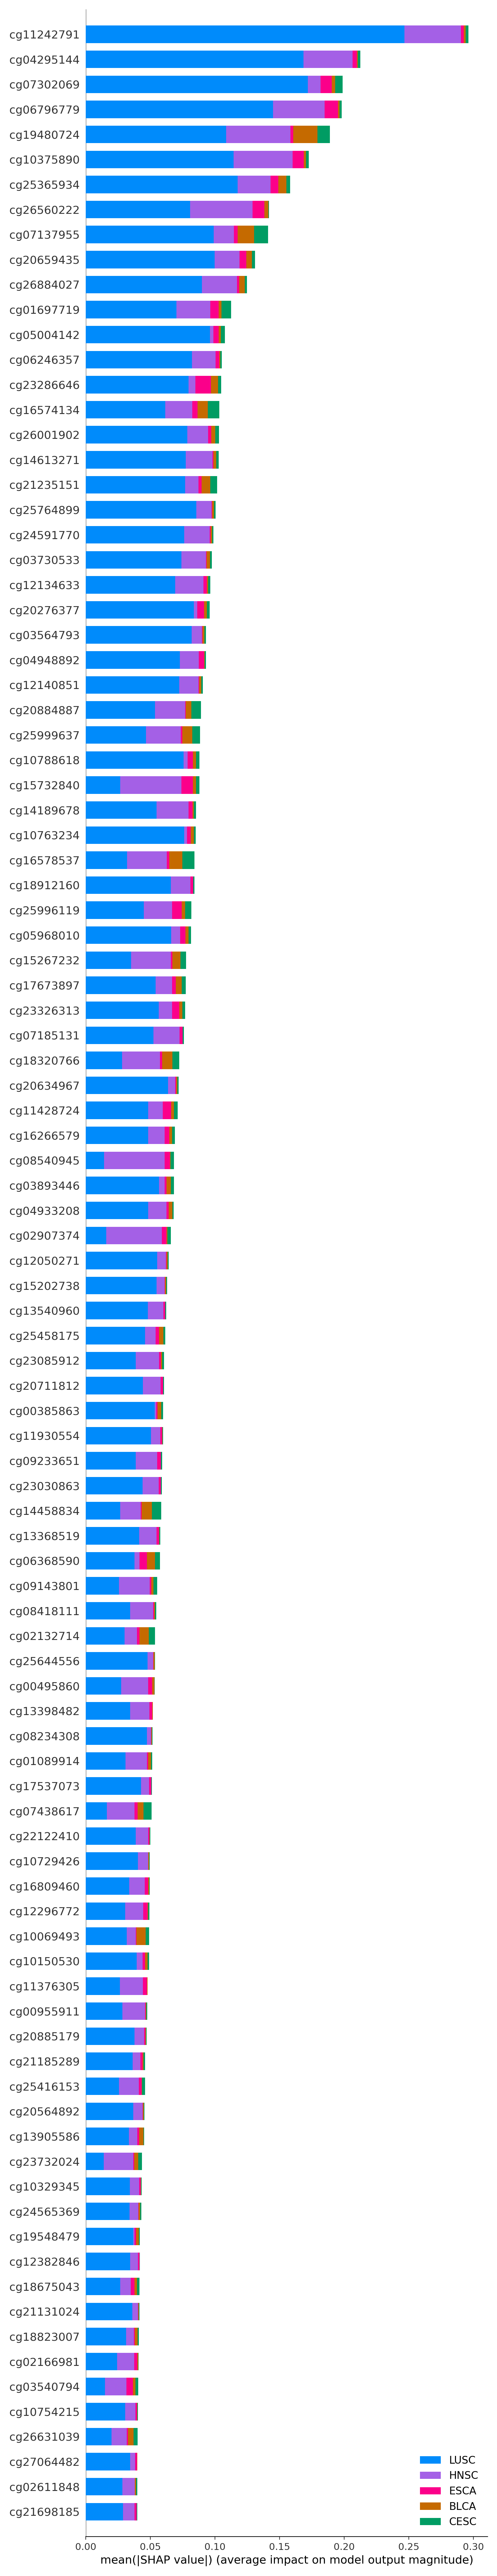

In [325]:
shap.summary_plot(shap_values, test_dat, feature_names=selected_probes, class_names=le.classes_, max_display=100)

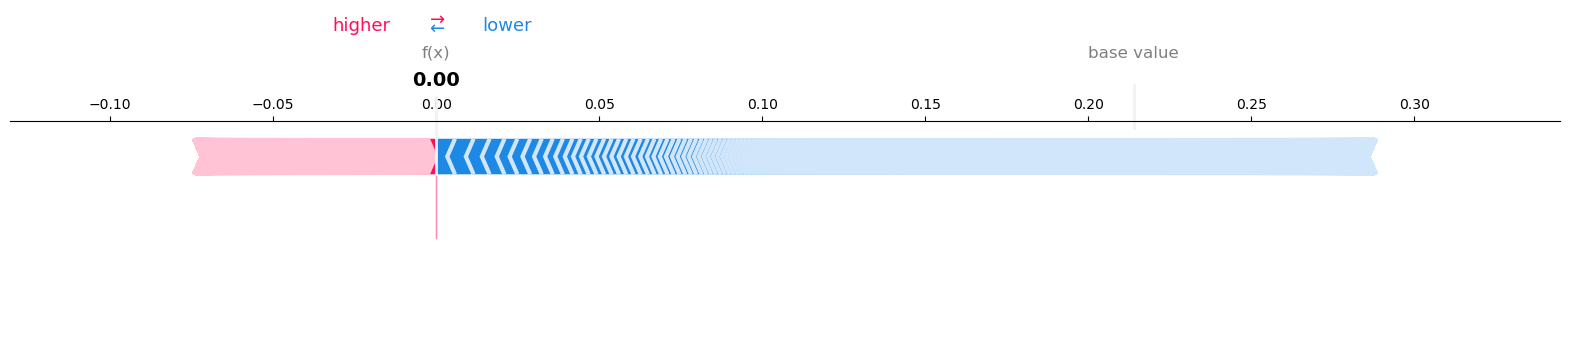

In [342]:
shap.force_plot(e.expected_value[0], shap_values[0][0], test_dat[0].to('cpu').tolist(), matplotlib=True)

In [340]:
shap_values_absmean = np.array([np.mean(np.abs(x), axis=0) for x in shap_values]).T

pd.DataFrame(shap_values_absmean, index=selected_probes, columns=le.classes_).rename_axis('probe').reset_index().to_csv(here('results/classifier/nn_shapley.tsv'), sep='\t', index=False)

In [341]:
pd.DataFrame({'probe': selected_probes}).to_csv(here('results/classifier/selected_probes.tsv'), sep='\t', index=False)

In [343]:
shap_values_mean = np.array([np.mean(x, axis=0) for x in shap_values]).T

pd.DataFrame(shap_values_mean, index=selected_probes, columns=le.classes_).rename_axis('probe').reset_index().to_csv(here('results/classifier/nn_shapley_no_abs.tsv'), sep='\t', index=False)